In [ ]:
# IMPORTS
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.fft import irfft, rfft, rfftfreq, fft, fftfreq, fftshift, ifft
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import norm
import pandas as pd
from scipy.special import wofz
from scipy.optimize import curve_fit
from scipy.signal import welch, get_window
%matplotlib widget 
from funcs_peak_fitting import *
from funcs_dsp import *
from funcs_df import load_df

In [ ]:
# Load dataframe
laptop = True
dfs_to_load = ["Curated Data"] # If this is empty, all are loaded
df = load_df(laptop=laptop, dfs_to_load=dfs_to_load)
# Crop to only wf
df = df[df['wf'].notna()]
# Crop to only species
df_human = df[df['species'].isin(["Human"])]
df_lizard = df[df['species'].isin(["Lizard", "Anolis"])]


In [ ]:
# Grab waveforms
h_idx = 0
l_idx = 0

wf_human = df_human.iloc[h_idx]['wf']
wf_lizard = df_lizard.iloc[l_idx]['wf']
fs_human = df_human.iloc[h_idx]['sr']
fs_lizard = df_lizard.iloc[l_idx]['sr']
if fs_human == fs_lizard:
    fs = fs_human
else:
    raise("Shouldn't these all have the same samplerate?")

In [ ]:
""" Get PSDs and plot SOAE data """
plt.close('all')
# Parameters
scaling = "density"
detrend = None # No detrending
win_type = 'boxcar'
nperseg = 32768
zpad = 2
nfft = nperseg*zpad
log = False
f_min = 500 # Set minimum frequency for crop

f_human, psd_human = welch(wf_human, scaling=scaling, fs=fs, window=win_type, nperseg=nperseg, nfft=nfft, detrend=detrend)
f_lizard, psd_lizard = welch(wf_lizard, scaling=scaling, fs=fs, window=win_type, nperseg=nperseg, nfft=nfft, detrend=detrend)


if np.array_equal(f_human, f_lizard):
    f = f_human
else:
    raise("Why aren't these the same?")

f_min_idx = np.argmin(np.abs(f - f_min)) # Convert frequency to index
f_max_idx = f_min_idx + 4096*zpad

# Crop frequencies
f_cropped = f[f_min_idx:f_max_idx]
psd_lizard = psd_lizard[f_min_idx:f_max_idx]
psd_human = psd_human[f_min_idx:f_max_idx]



for psd, species in zip([psd_human, psd_lizard], ["Human", "Lizard"]):
    plt.figure(figsize=(10, 5))
    if scaling == 'spectrum':
        label = "Power Spectrum"
        ylabel = "PS"
    elif scaling == 'density':
        label = "Power Spectral Density"
        ylabel = "PSD"
        
    if log:
        # Convert to log
        psd = 10 * np.log10(psd)
        ylabel += " (Log)"
    else:
        ylabel += " (Linear)"
    
    if detrend == "constant":
        label += " (Detrended)"
    elif detrend == False:
        label += " (Not Detrended)"
        
    label+=f": nperseg={nperseg}"
    plt.title(f"{species} PSD (Cropped)")
    plt.plot(f_cropped, psd, label="Proposed Crop")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()
    

In [ ]:
# Define fitting function


def fit_peak(x, y, f0, y0, amp, gamma, sigma, f_hw=100, log=False, species=None):
    voigt, lorentz, gauss, lorentz_smeared = Voigt, Lorentzian, Gauss, Lorentzian_conv
    # Calculate min and max freq idx to crop
    f_min = f0 - f_hw
    f_max = f0 + f_hw
    f_min_idx = np.argmin(np.abs(x - f_min))
    f_max_idx = np.argmin(np.abs(x - f_max))
    x = x[f_min_idx:f_max_idx]
    y = y[f_min_idx:f_max_idx]
    
    # Set bounds (strangely, I have to let amp run negative to get a good fit...)
    bounds = (
        [f_min, 0, -1, 0, 0], # f0, y0, amp, gamma, sigma
        [f_max, np.inf, np.inf, np.inf, np.inf] 
    )
    
    # Set initial guess
    p0 = [f0, y0, amp, gamma, sigma]
    
    # Crop bounds/p0 for gauss and lorentz dirichlete less params
    bounds_lorentz = (bounds[0][:4], bounds[1][:4])
    p0_lorentz = p0[0:4]
    bounds_gauss = (bounds[0][:3] + [bounds[0][4]], bounds[1][:3] + [bounds[1][4]])
    p0_gauss = p0[0:3] + p0[4:]
    # bounds_dirichlet = (bounds[0][:3], bounds[1][:3])
    # p0_dirichlet = p0[0:3]
    
    
    
    lorentz_params, lorentz_cov = curve_fit(lorentz, x, y, bounds=bounds_lorentz, p0=p0_lorentz)
    gauss_params, gauss_cov = curve_fit(gauss, x, y, bounds=bounds_gauss, p0=p0_gauss)
    voigt_params, voigt_cov = curve_fit(voigt, x, y, bounds=bounds, p0=p0)
    # dirichlet_params, dirichlet_cov = curve_fit(dirichlet_mag, x, y, bounds=bounds_dirichlet, p0=p0_dirichlet)
    lorentz_smeared_params, lorentz_smeared_cov = curve_fit(lorentz_smeared, x, y, bounds=bounds_lorentz, p0=p0_lorentz)

    lorentz_fit = lorentz(x, *lorentz_params)
    gauss_fit = gauss(x, *gauss_params)
    voigt_fit = voigt(x, *voigt_params)
    # dirichlet_fit = dirichlet_mag(x, *dirichlet_params)
    lorentz_smeared_fit = lorentz_smeared(x, *lorentz_params)

    print("")
    
    # Print MSE Details
    scale1e = -22
    best_mse = np.inf
    best_type = None

    for type, fit in zip(["Lorentzian", "Gaussian", "Voigt",  "Lorentz Smeared"], [lorentz_fit, gauss_fit, voigt_fit, lorentz_smeared_fit]):
        mse = np.mean((fit - y)**2)
        if best_mse > mse:
            best_mse = mse
            best_type = type
        
        print(f"MSE (1e{scale1e}) of {type} = {mse*(10**-scale1e):.2f}")
    
    print(f"Best Fit = {best_type}")
    
    print("")
    
    # Print fitting parameters
    
    print("LORENTZIAN")
    print(f"f0 = {lorentz_params[0]:.2f}, y0 = {lorentz_params[1]*10**10:.2f}e-10, amp = {lorentz_params[2]*10**10:.2f}e-10, Gamma (HWHM) = {lorentz_params[-1]:.2f}")
    print("LORENTZIAN SMEARED")
    print(f"f0 = {lorentz_smeared_params[0]:.2f}, y0 = {lorentz_smeared_params[1]*10**10:.2f}e-10, amp = {lorentz_smeared_params[2]*10**10:.2f}e-10, Gamma (HWHM) = {lorentz_smeared_params[-1]:.2f}")
    print("GAUSSIAN")
    print(f"f0 = {gauss_params[0]:.2f}, y0 = {gauss_params[1]*10**10:.2f}e-10, amp = {gauss_params[2]*10**10:.2f}e-10, Sigma = {gauss_params[-1]:.2f}, HWHM = {get_gauss_hwhm(gauss_params[-1]):.2f}")
    print(f"VOIGT")
    print(f"f0 = {voigt_params[0]:.2f}, y0 = {voigt_params[1]*10**10:.2f}e-10, amp = {voigt_params[2]*10**10:.2f}e-10, Gamma = {voigt_params[-2]:.2f}, Sigma = {voigt_params[-1]:.2f}, HWHM = {get_voigt_hwhm(voigt_params[-2], voigt_params[-1]):.2f}")
    # print(f"SINC")
    # print(f"f0 = {dirichlet_params[0]:.2f}, y0 = {dirichlet_params[1]*10**10:.2f}e-10, amp = {dirichlet_params[2]*10**10:.2f}e-10")
    
    print("")
    

    ylabel = "PSD"
    if log:
        y = 10*np.log10(y)
        ylabel = ylabel + " (Log)"
        
    plt.close('all')
    plt.figure(figsize=(10, 5))
    plt.title(f"Peak Shape Fit")
    if species is not None:
        plt.title(f"Peak Shape Fit ({species})")
    plt.scatter(x, y, label="Original PSD", alpha=0.5, s=5, color='g', zorder=4)
    plt.plot(x, voigt_fit, label="Voigt Fit", color='c', zorder=1)
    plt.plot(x, lorentz_fit, label="Lorentzian Fit", color='b', zorder=2)
    plt.plot(x, gauss_fit, label="Gaussian Fit", color='m', zorder=3)
    plt.plot(x, lorentz_smeared_fit, label="Smeared Lorentzian Fit", color='y', zorder=5)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [ ]:
"Lizard Peak Shape Fitting"
x = f_cropped
y = psd_lizard
log = False # Log scale
f_hw = 150 # Amount on either side to include
# Initial Guesses
f0 = 3710 # Peak center
y0 = 0 # Vertical shift
amp = 1e-8 # Peak max
gamma = 1 # FWHM of Lorentzian, or "amount" of Lorentzian in Voigt
sigma = 1 # Std of Gaussian, or "amount" of Gaussian in Voigt

print("Lizard SOAE Peak Fitting")
fit_peak(x, y, f0, y0, amp, gamma, sigma, f_hw=f_hw, log=False, species=None)

In [ ]:
"Human Peak Shape Fitting"
species = "Human"
x = f_cropped
y = psd_human
log = False # Log scale
f_hw = 5 # Amount on either side to include
# Initial Guesses
f0 = 2252 # Peak center (4372, 2252)
y0 = 0 # Vertical shift
amp = 3e-7 # Peak max
gamma = 1 # FWHM of Lorentzian, or "amount" of Lorentzian in Voigt
sigma = 1 # Std of Gaussian, or "amount" of Gaussian in Voigt


fit_peak(x, y, f0, y0, amp, gamma, sigma, f_hw=f_hw, log=log, species=species)

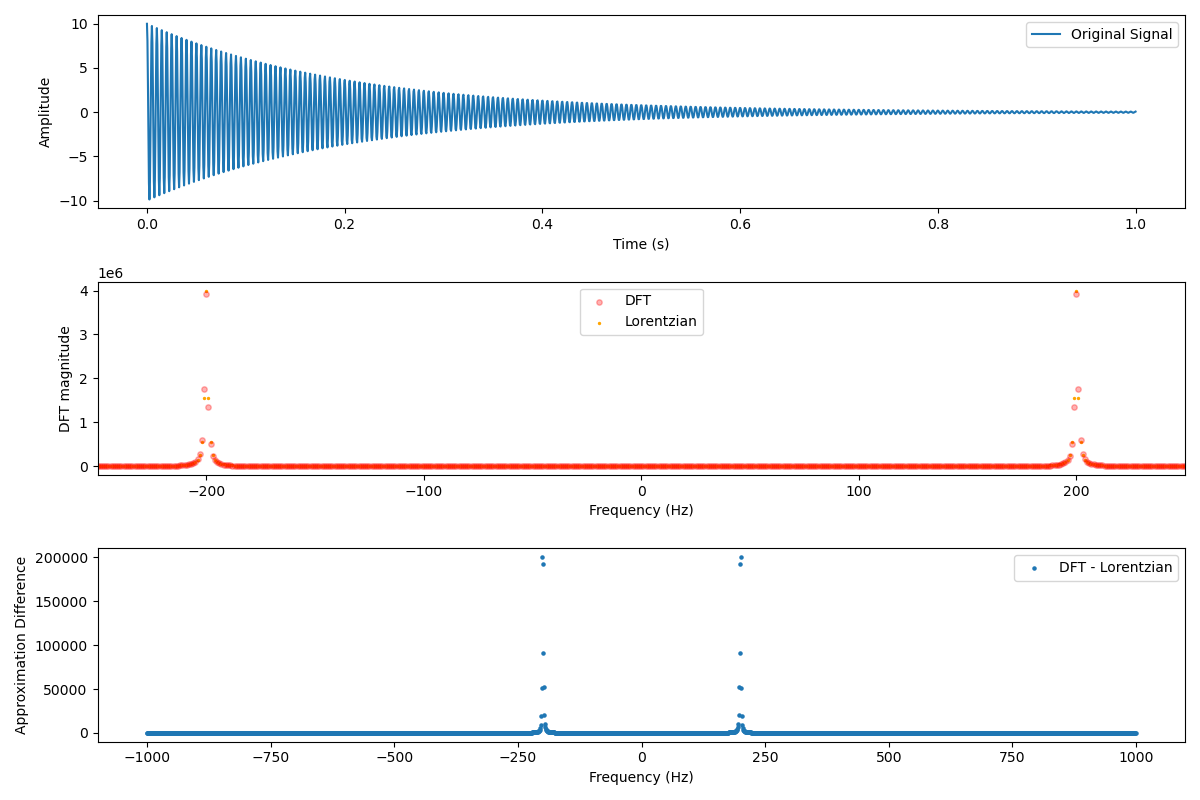

In [36]:
"Toy damped sinusoid fitting"
import numpy as np
import matplotlib.pyplot as plt
plt.close('all')


# Generate synthetic data with noise
np.random.seed(42)

fs = 2000
t_max  = 1
t = np.linspace(0, t_max, fs)
N = len(t)
f0 = 200
y0 = 0
A = 10
gamma = 5
phi = 0
sigma_noise = 0

y = A * np.cos(f0*2*np.pi*t + phi) * np.exp(-gamma * np.abs(t)) + np.random.normal(0, sigma_noise, t.size)
dft = np.fft.fft(y)
f = np.fft.fftfreq(len(t), 1 / fs)

# Calculate normalized radial frequency
w = 2 * np.pi * f / fs
w0 = 2 * np.pi * f0 / fs

# Calculate the corresponding DFT amplitude
"""
||DTFT||^2 ~ (A^2 / 4) * (1 / [gamma^2 + (w - w0)^2])
Lorentz = amp * gamma^2 * (1 / [gamma^2 + (f - f0)^2])
"""
amp_sim_lineshape = (A / (2*gamma))**2

# Generate simulated lineshapes
lorentz_minimal_simulation = Lorentzian(f, f0, y0, amp_sim_lineshape, gamma / 2 / np.pi) + Lorentzian(f, -f0, y0, amp_sim_lineshape, gamma / 2 / np.pi)


# Account for the fact that the pair of Lorentzians will be scaled by N by the convolution with boxcar DTFT
lorentz_minimal_simulation = lorentz_minimal_simulation * N**2

# Plot the results
n_plots = 3
plt.figure(figsize=(12, 8))

plt.subplot(n_plots, 1, 1)
plt.plot(t, y, label="Original Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()



plt.subplot(n_plots, 1, 2)
plt.scatter(f, (np.abs(dft))**2, label="DFT", s=15, alpha=0.3, color='red', zorder = 2)
plt.scatter(f, lorentz_minimal_simulation , label="Lorentzian", color='orange', s=2, zorder=1)
# lorentz_conv_simulation = Lorentzian_conv(f, f0, y0, A, gamma / 2 / np.pi / fs, N, fs)
# plt.scatter(f, lorentz_conv_simulation, label="Lorentzian (convolved)", s=5)
plt.xlabel("Frequency (Hz)")
plt.ylabel("DFT magnitude")
plt.xlim(-250, 250)
plt.legend()

plt.subplot(n_plots, 1, 3)
plt.scatter(f, np.abs((np.abs(dft))**2 - lorentz_minimal_simulation), label="DFT - Lorentzian", s=5)
# plt.scatter(f, (np.abs(dft))**2 - lorentz_conv_simulation, label="DFT - Lorentzian (convolved)", s=5)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Approximation Difference")
plt.legend()

plt.tight_layout()
plt.show()




In [ ]:
"Toy Voigt Fitting"
# Generate synthetic data with noise
np.random.seed(42)
x = np.linspace(2100, 2200, 2000)
x0, y0, amp, gamma, sigma = 2150, 0, 1, 1e-10, 1
y_true = Voigt(x, x0, y0, amp, gamma, sigma)
noise = np.random.normal(0, 0.05, x.size)
y = y_true + noise

p0 = (x0, y0, amp, gamma, sigma)
fitted_params, covariance = curve_fit(Voigt, x, y, p0=p0)

# Extract the fitted parameters
x0_fitted, y0_fitted, amp_fitted, sigma_fitted, gamma_fitted = fitted_params
print("Fitted Parameters:")
print(f"x0: {x0_fitted:.3f}, y0: {y0_fitted:.3f}, Amplitude: {amp_fitted:.3f}, Sigma: {sigma_fitted:.3f}, Gamma: {gamma_fitted:.3f}")

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'b.', label='Data')
plt.plot(x, y_true, 'k--', label='True Voigt Profile', zorder=2)
plt.plot(x, Voigt(x, *fitted_params), 'r-', label='Fitted Voigt Profile', zorder=1)
# plt.plot(x, Gauss(x, x0, y0, amp, sigma), label="Gaussian")
# plt.plot(x, Lorentz(x, x0, y0, amp, gamma), label="Lorentz")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Nonlinear Curve Fitting for a Voigt Distribution")
plt.show()


In [ ]:
# What if we do our fitting in the dB scale like Chris did?
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the Lorentzian function
def lorentzian(x, amplitude, x0, gamma, y0):
    return amplitude * (gamma**2) / ((x - x0)**2 + gamma**2) + y0

# Convert to dB with a small offset to avoid log(0)
def to_db(y, offset=1e-10):
    return 10 * np.log10(y + offset)


# Generate synthetic data
def generate_data(amplitude, x0, gamma, x_min, x_max, num_points):
    x = np.linspace(x_min, x_max, num_points)
    y = lorentzian(x, amplitude, x0, gamma, y0)
    y_db = to_db(y)
    return x, y, y_db

# Curve fitting function
def fit_lorentzian(x, y_db):
    # Initial guesses for amplitude, x0, gamma
    initial_guess = [np.max(y_db), x[np.argmax(y_db)], 1.0, 10]
    popt, _ = curve_fit(lorentzian, x, y_db, p0=initial_guess)
    return popt

# Parameters
amplitude = 10.0  # Height of the peak
x0 = 0.0         # Center of the peak
y0 = 10
gamma = 10.0      # Half width at half maximum (HWHM)
x_min = x0 - 10.0
x_max = x0 + 10.0
num_points = 100

# Generate data
x, y, y_db = generate_data(amplitude, x0, gamma, x_min, x_max, num_points)

# Fit the data
popt = fit_lorentzian(x, y)
amplitude_fit, x0_fit, gamma_fit, y0_fit = popt

# Output the detected FWHM
print(f"Detected HWHM: {gamma_fit:.2f}")
print(f"Detected amplitude: {amplitude_fit:.2f}")
print(f"MSE: {np.mean((y - lorentzian(x, *popt))**2):.2f}")

# Fit the data
popt_dB = fit_lorentzian(x, y_db)
amplitude_fit_dB, x0_fit_dB, gamma_fit_dB, y0_fit_dB = popt_dB
# Output the detected FWHM
print(f"Detected HWHM (dB version): {gamma_fit_dB:.2f}")
print(f"Detected amplitude (dB version): {amplitude_fit_dB:.2f}")
print(f"MSE (dB version): {np.mean((y - lorentzian(x, *popt))**2):.2f}")


# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'g-', label='Data')
plt.plot(x, lorentzian(x, *popt), 'r--', label='Fit')
plt.plot(x, y_db, 'b-', label='Data (dB)')
plt.plot(x, lorentzian(x, *popt_dB), 'y--', label='Fit (dB)')
plt.title(f"Lorentzian Peak (dB vs non-dB)")
plt.xlabel('x')
plt.ylabel('Amplitude (dB)')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
""" Double checking my convolutions """
# Parameters
nperseg = 32768
fs = 44100  # Sampling frequency
pad_factor = 8 # Zero-padding factor
f0 = 3000 # Frequency center
y0 = 0 # Offset
amp = 1 # Amplitude 
gamma = 2 # HWHM

# Calculate some padding related things
pad_width = int(nperseg * pad_factor / 2)
N_padded = nperseg + pad_width * 2

# Generate the windows
boxcar_window = get_window('boxcar', nperseg)

# Zero-padding the windows (adding zeros on either side)
zero_padded_boxcar = np.pad(boxcar_window, pad_width)  # Pad with zeros to N_padded length

# Compute the Fourier Transform of the zero-padded windows
boxcar_ft = fft((zero_padded_boxcar))
boxcar_mags = np.abs(boxcar_ft)

# Get frequency axis and normalized radial frequency axis
f = fftfreq(N_padded, 1/fs)
w_hat = 2 * np.pi * f / fs

# Plot
plt.figure(figsize=(8, 4))
plot_width = 10

plt.subplot(2, 2, 2)
plt.scatter(f, boxcar_mags, s=1)
plt.title('True Boxcar Window Mags (Padded)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(-plot_width, plot_width)

plt.subplot(2, 2, 1)
plt.scatter(f, np.abs(boxcar_DTFT(w_hat, nperseg, fs)), s=1)
plt.xlim(-plot_width, plot_width)
plt.title("Analytically Derived Boxcar Window Mags")

plt.subplot(2, 2, 3)
plt.scatter(f, Lorentzian(f, f0, y0, amp, gamma), s=1)
plt.xlim(f0 - plot_width, f0 + plot_width)
plt.title("Lorentz Mags")

plt.subplot(2, 2, 4)
plt.scatter(f, Lorentzian_conv(f, f0, y0, amp, gamma, nperseg, fs), s=1)
plt.xlim(f0 - plot_width, f0 + plot_width)
plt.title("Convolved Lorentz Mags")

plt.tight_layout()
plt.show()



In [ ]:
"DELETE"
# # Lorentzian peak

# # (Sampled) DTFT of a boxcar window with nperseg nonzero points
# def boxcar_DTFT(x, nperseg, fs):
#     def func(x):
#         return (np.sin((nperseg + 1) * x * np.pi / fs) / np.sin((x) * np.pi / fs)) * np.exp(1j * nperseg * np.pi * x / fs) # omega == > 2*pi * x / fs
#     # Handle the case where x = 0
#     if np.any(x == 0):
#         center_idx = np.where(x == 0)[0][0]
#         result = np.empty_like(x, dtype=complex)
#         result[0:center_idx] = func(x[0:center_idx])
#         result[center_idx + 1:] = func(x[center_idx + 1:])
#         result[center_idx] = (nperseg + 1)
#     else:
#         result = func(x)
#     return result / (nperseg + 1)

# # Convolution of Lorentz with the boxcar
# def Lorentzian_conv(x, x0, y0, amp, gamma, nperseg, fs):
#     """
#     Compute the convolution of a Lorentzian peak with a boxcar function.
    
#     Parameters:
#         x (array): Positive half of FFT frequencies (starting from 0).
#         x0 (float): Center of the Lorentzian peak.
#         y0 (float): Offset of the Lorentzian peak.
#         amp (float): Amplitude of the Lorentzian peak.
#         gamma (float): Half-width at half-maximum (HWHM) of the Lorentzian peak.
#         nperseg (int): Length of the boxcar function.
#         fs (float): Sampling frequency.
    
#     Returns:
#         array: Convolution result corresponding to the original indices of x, with the peak preserved.
#     """
#     # Compute the Lorentzian function peaks (positive and negative)
#         # Is this bleeding of the positve freq peak into the negative freqs (and vice versa) correct?
#     lorentz = Lorentzian(x, x0, y0, amp, gamma) + Lorentzian(x, -x0, y0, amp, gamma) 
#     # Compute the boxcar DTFT (on the full frequency array)
#     boxcar = boxcar_DTFT(x, nperseg, fs)
#     # Circular convolution via FFTs
#     result = np.real(np.fft.ifft(np.fft.fft(lorentz)*np.fft.fft(boxcar)))
#     # print(np.max(lorentz)) = 0.999990797972314
#     # print(np.max(result)) = 1.9747915953417552 ??? Expected this to be ~ 1
#     return np.abs(result)